In [1]:
%tensorflow_version 1.14
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

import keras
keras.__version__

!pip install numpy==1.16.1
import numpy as np

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.


Using TensorFlow backend.


     |████████████████████████████████| 17.3MB 236kB/s 
ERROR: tensorflow 1.15.2 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.18.2
    Uninstalling numpy-1.18.2:
      Successfully uninstalled numpy-1.18.2


# Classifying newswires: a multi-class classification example

In this homework, we will build a network to classify Reuters newswires into 46 different mutually-exclusive topics. Since we have many 
classes, this problem is an instance of "multi-class classification", and since each data point should be classified into only one 
category, the problem is more specifically an instance of "single-label, multi-class classification".

## The Reuters dataset


We will be working with the _Reuters dataset_, a set of short newswires and their topics, published by Reuters in 1986. It's a very simple, 
widely used toy dataset for text classification. There are 46 different topics; some topics are more represented than others, but each 
topic has at least 10 examples in the training set.

Like IMDB and MNIST, the Reuters dataset comes packaged as part of Keras. Let's take a look right away:

In [0]:
from keras.datasets import reuters

(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)


Like with the IMDB dataset, the argument `num_words=10000` restricts the data to the 10,000 most frequently occurring words found in the 
data.

We have 8,982 training examples and 2,246 test examples:

As with the IMDB reviews, each example is a list of integers (word indices):

In [4]:
train_data[0]

[1,
 2,
 2,
 8,
 43,
 10,
 447,
 5,
 25,
 207,
 270,
 5,
 3095,
 111,
 16,
 369,
 186,
 90,
 67,
 7,
 89,
 5,
 19,
 102,
 6,
 19,
 124,
 15,
 90,
 67,
 84,
 22,
 482,
 26,
 7,
 48,
 4,
 49,
 8,
 864,
 39,
 209,
 154,
 6,
 151,
 6,
 83,
 11,
 15,
 22,
 155,
 11,
 15,
 7,
 48,
 9,
 4579,
 1005,
 504,
 6,
 258,
 6,
 272,
 11,
 15,
 22,
 134,
 44,
 11,
 15,
 16,
 8,
 197,
 1245,
 90,
 67,
 52,
 29,
 209,
 30,
 32,
 132,
 6,
 109,
 15,
 17,
 12]

Here's how you can decode it back to words, in case you are curious:

In [5]:
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# Note that our indices were offset by 3
# because 0, 1 and 2 are reserved indices for "padding", "start of sequence", and "unknown".
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

print("The decoded text:" + decoded_newswire)

557056/550378 [==============================] - 1s 2us/step
The decoded text:? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


The label associated with an example is an integer between 0 and 45: a topic index.

In [6]:
train_labels[0]

3

## Preparing the data

We can vectorize the data with the exact same code as in our previous example:

In [0]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# Our vectorized training data
x_train = vectorize_sequences(train_data)
# Our vectorized test data
x_test = vectorize_sequences(test_data)


Use "one-hot" encoding to vectorize the labels. One-hot encoding is a widely used format for categorical data, also called "categorical encoding". In our case, one-hot encoding of our labels consists in embedding each label as an all-zero vector with a 1 in the place of the label index. Note that there is a built-in way to do this in Keras.

In [0]:
from keras.utils.np_utils import to_categorical

one_hot_train_labels = to_categorical(train_labels)
one_hot_test_labels = to_categorical(test_labels)

## Building our network


This topic classification problem looks very similar to our previous movie review classification problem: in both cases, we are trying to 
classify short snippets of text. There is however a new constraint here: the number of output classes has gone from 2 to 46, i.e. the 
dimensionality of the output space is much larger. 

In a stack of `Dense` layers like what we were using, each layer can only access information present in the output of the previous layer. 
If one layer drops some information relevant to the classification problem, this information can never be recovered by later layers: each 
layer can potentially become an "information bottleneck". In our previous example, we were using 16-dimensional intermediate layers, but a 
16-dimensional space may be too limited to learn to separate 46 different classes: such small layers may act as information bottlenecks, 
permanently dropping relevant information.

For this reason we will use larger layers. Let's go with 64 units:

In [12]:
from keras import models
from keras import layers

# TODO: specify the architecture of the model.
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 46)                2990      
Total params: 647,214
Trainable params: 647,214
Non-trainable params: 0
_________________________________________________________________



There are two other things you should note about this architecture:

* We are ending the network with a `Dense` layer of size 46. This means that for each input sample, our network will output a 
46-dimensional vector. Each entry in this vector (each dimension) will encode a different output class.
* The last layer uses a `softmax` activation. You have already seen this pattern in the MNIST example. It means that the network will 
output a _probability distribution_ over the 46 different output classes, i.e. for every input sample, the network will produce a 
46-dimensional output vector where `output[i]` is the probability that the sample belongs to class `i`. The 46 scores will sum to 1.

The best loss function to use in this case is `categorical_crossentropy`. It measures the distance between two probability distributions: 
in our case, between the probability distribution output by our network, and the true distribution of the labels. By minimizing the 
distance between these two distributions, we train our network to output something as close as possible to the true labels.

In [0]:
# TODO: compile the model you just built

from keras import optimizers
from keras import losses
from keras import metrics

model.compile(optimizer=optimizers.RMSprop(lr=0.001),
              loss=losses.categorical_crossentropy,
              metrics=[metrics.categorical_accuracy])

## Validating our approach

Let's set apart 1,000 samples in our training data to use as a validation set:

In [0]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

Now let's train our network for 20 epochs:

In [20]:
# TODO: fit the model with the training dataset and provide validation data 
# to help check overfitting
history = history = model.fit(partial_x_train, partial_y_train, epochs=20, 
                              batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 197us/step - loss: 2.6075 - categorical_accuracy: 0.5159 - val_loss: 1.7086 - val_categorical_accuracy: 0.6380
Epoch 2/20
7982/7982 [==============================] - 1s 127us/step - loss: 1.4010 - categorical_accuracy: 0.7136 - val_loss: 1.2942 - val_categorical_accuracy: 0.7230
Epoch 3/20
7982/7982 [==============================] - 1s 129us/step - loss: 1.0285 - categorical_accuracy: 0.7783 - val_loss: 1.1139 - val_categorical_accuracy: 0.7740
Epoch 4/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.7992 - categorical_accuracy: 0.8305 - val_loss: 1.0352 - val_categorical_accuracy: 0.7810
Epoch 5/20
7982/7982 [==============================] - 1s 126us/step - loss: 0.6334 - categorical_accuracy: 0.8656 - val_loss: 0.9732 - val_categorical_accuracy: 0.8130
Epoch 6/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.5047 - categorical_acc

Let's display its loss and accuracy curves to help identify when it starts to overfit.

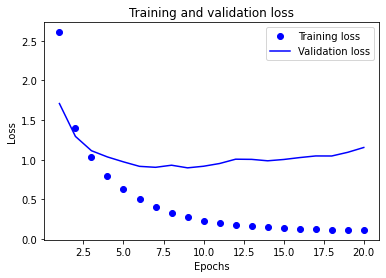

In [25]:
import matplotlib.pyplot as plt

# TODO: plot the model loss on both training and validation data. 

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

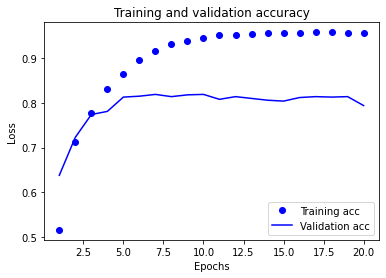

In [26]:
# TODO: plot prediction accuracy on both training and validation data. 
plt.clf()
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

It seems that the network starts overfitting after certain epochs. Let's train a new network from scratch for fewer epochs before it starts overfitting, then let's evaluate it on the test set:

In [28]:
# TODO: retrain the model with the fewer epoches to avoid overfitting
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit( partial_x_train, partial_y_train, epochs=9, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 1s 147us/step - loss: 2.6893 - accuracy: 0.5563 - val_loss: 1.7410 - val_accuracy: 0.6570
Epoch 2/9
7982/7982 [==============================] - 1s 129us/step - loss: 1.3999 - accuracy: 0.7100 - val_loss: 1.3073 - val_accuracy: 0.7200
Epoch 3/9
7982/7982 [==============================] - 1s 131us/step - loss: 1.0305 - accuracy: 0.7798 - val_loss: 1.1398 - val_accuracy: 0.7510
Epoch 4/9
7982/7982 [==============================] - 1s 128us/step - loss: 0.8135 - accuracy: 0.8312 - val_loss: 1.0338 - val_accuracy: 0.7950
Epoch 5/9
7982/7982 [==============================] - 1s 130us/step - loss: 0.6431 - accuracy: 0.8690 - val_loss: 0.9793 - val_accuracy: 0.7930
Epoch 6/9
7982/7982 [==============================] - 1s 129us/step - loss: 0.5151 - accuracy: 0.8974 - val_loss: 0.9344 - val_accuracy: 0.8040
Epoch 7/9
7982/7982 [==============================] - 1s 130us/step - loss: 0.414


Your model should reach an accuracy of ~78%. With a balanced binary classification problem, the accuracy reached by a purely random classifier 
would be 50%, but in our case it is closer to 19%, so our results seem pretty good, at least when compared to a random baseline.

## Generating predictions on new data

We can verify that the `predict` method of our model instance returns a probability distribution over all 46 topics. Let's generate topic 
predictions for all of the test data:

In [29]:
# TODO: use the learnt neural network to make a prediction on 
# the test data 
predict = model.predict(x_test)
predict

array([[4.31233002e-06, 6.90595925e-06, 1.36663548e-05, ...,
        1.44081550e-05, 5.63186120e-07, 1.78323376e-06],
       [1.86676520e-03, 7.83132166e-02, 2.02660868e-03, ...,
        8.35797051e-04, 1.42953177e-05, 3.60932492e-04],
       [1.64196678e-02, 8.86717081e-01, 3.69732617e-03, ...,
        5.98662125e-04, 1.03705686e-04, 3.97050841e-04],
       ...,
       [7.71724990e-06, 1.89128095e-05, 6.49017456e-05, ...,
        2.72528414e-05, 1.85898830e-06, 1.62415915e-06],
       [5.80018561e-04, 7.57178990e-03, 3.17204418e-03, ...,
        5.20201284e-04, 9.58092278e-05, 5.97224804e-04],
       [2.15016829e-04, 2.88763613e-01, 6.07406115e-03, ...,
        2.66141212e-03, 4.82790289e-04, 1.38231000e-04]], dtype=float32)

Each entry in `predictions` is a vector of length 46. **The** largest entry is the predicted class, i.e. the class with the highest probability:

In [30]:
# TODO: evaluate model performan in terms of accuracy on prediction against the ground truth.
test_loss, test_acc=model.evaluate(x_test,predict)

2246/2246 [==============================] - 0s 111us/step


In [31]:
predict.shape

(2246, 46)

In [32]:
print('test_acc:', test_acc)

test_acc: 1.0


## On the importance of having sufficiently large intermediate layers


We mentioned earlier that since our final outputs were 46-dimensional, we should avoid intermediate layers with much less than 46 hidden 
units. Now let's try to see what happens when we introduce an information bottleneck by having intermediate layers significantly less than 
46-dimensional, e.g. 4-dimensional.

In [33]:
# TODO: build a neural network with 4 neuron units in the hidden layer with the validation data 
# and evaluate its performance on the test data.
model_2 = models.Sequential()
model_2.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_2.add(layers.Dense(4, activation='relu'))
model_2.add(layers.Dense(46, activation='softmax')) 

model_2.compile( optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 174us/step - loss: 3.5881 - accuracy: 0.1131 - val_loss: 3.3488 - val_accuracy: 0.2700
Epoch 2/20
7982/7982 [==============================] - 1s 128us/step - loss: 3.1625 - accuracy: 0.2717 - val_loss: 3.0549 - val_accuracy: 0.2680
Epoch 3/20
7982/7982 [==============================] - 1s 128us/step - loss: 2.8639 - accuracy: 0.2767 - val_loss: 2.8414 - val_accuracy: 0.2680
Epoch 4/20
7982/7982 [==============================] - 1s 126us/step - loss: 2.6470 - accuracy: 0.2864 - val_loss: 2.6895 - val_accuracy: 0.2770
Epoch 5/20
7982/7982 [==============================] - 1s 128us/step - loss: 2.4723 - accuracy: 0.2998 - val_loss: 2.5592 - val_accuracy: 0.2820
Epoch 6/20
7982/7982 [==============================] - 1s 126us/step - loss: 2.3057 - accuracy: 0.3106 - val_loss: 2.4233 - val_accuracy: 0.2920
Epoch 7/20
7982/7982 [==============================] - 1s 127us/step - loss


You should see the model performance drop. This drop is mostly due to the fact that we are now trying to compress a lot of information (enough information to recover the separation hyperplanes of 46 classes) into an intermediate space that is too low-dimensional. The network is able to cram _most_ of the necessary information into these 8-dimensional representations, but not all of it.

## Try using larger or smaller hidden layers: 32 units, and 128 units, and see if you will be able to improve the model performance on the test data.


In [34]:
# TODO: Try using larger or smaller hidden layers: 32 units, and 128 units
model_3 = models.Sequential()
model_3.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_3.add(layers.Dense(32, activation='relu'))
model_3.add(layers.Dense(46, activation='softmax')) 

model_3.compile( optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_3.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 145us/step - loss: 2.7263 - accuracy: 0.4703 - val_loss: 1.8805 - val_accuracy: 0.6040
Epoch 2/20
7982/7982 [==============================] - 1s 125us/step - loss: 1.5398 - accuracy: 0.6770 - val_loss: 1.3931 - val_accuracy: 0.7000
Epoch 3/20
7982/7982 [==============================] - 1s 127us/step - loss: 1.1390 - accuracy: 0.7605 - val_loss: 1.2267 - val_accuracy: 0.7520
Epoch 4/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.9095 - accuracy: 0.8103 - val_loss: 1.1004 - val_accuracy: 0.7720
Epoch 5/20
7982/7982 [==============================] - 1s 127us/step - loss: 0.7364 - accuracy: 0.8522 - val_loss: 1.0143 - val_accuracy: 0.7880
Epoch 6/20
7982/7982 [==============================] - 1s 126us/step - loss: 0.5982 - accuracy: 0.8815 - val_loss: 0.9815 - val_accuracy: 0.7930
Epoch 7/20
7982/7982 [==============================] - 1s 127us/step - loss

In [35]:
result = model_3.evaluate(x_test,one_hot_test_labels)
print(result)

2246/2246 [==============================] - 0s 105us/step
[1.2403340980821917, 0.7822796106338501]


In [37]:
model_4 = models.Sequential()
model_4.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_4.add(layers.Dense(128, activation='relu'))
model_4.add(layers.Dense(46, activation='softmax')) 

model_4.compile( optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_4.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 155us/step - loss: 2.5410 - accuracy: 0.5366 - val_loss: 1.6175 - val_accuracy: 0.6600
Epoch 2/20
7982/7982 [==============================] - 1s 130us/step - loss: 1.3504 - accuracy: 0.7096 - val_loss: 1.2560 - val_accuracy: 0.7170
Epoch 3/20
7982/7982 [==============================] - 1s 132us/step - loss: 1.0183 - accuracy: 0.7772 - val_loss: 1.0997 - val_accuracy: 0.7500
Epoch 4/20
7982/7982 [==============================] - 1s 134us/step - loss: 0.7909 - accuracy: 0.8289 - val_loss: 1.0096 - val_accuracy: 0.7760
Epoch 5/20
7982/7982 [==============================] - 1s 132us/step - loss: 0.6127 - accuracy: 0.8711 - val_loss: 0.9237 - val_accuracy: 0.8050
Epoch 6/20
7982/7982 [==============================] - 1s 131us/step - loss: 0.4797 - accuracy: 0.8980 - val_loss: 0.9015 - val_accuracy: 0.8160
Epoch 7/20
7982/7982 [==============================] - 1s 133us/step - loss

In [38]:
result = model_4.evaluate(x_test,one_hot_test_labels)
print(result)

2246/2246 [==============================] - 0s 99us/step
[1.2411063613365085, 0.7889581322669983]



## We were using two hidden layers. Now try to use a single hidden layer, or three hidden layers, and see if you will be able to improve the model performance on the test data.



In [40]:
# TODO: Try to use a single hidden layer, or three hidden layers
model_5 = models.Sequential()
model_5.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_5.add(layers.Dense(46, activation='softmax')) 

model_5.compile(optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_5.fit(partial_x_train, partial_y_train, epochs=20, batch_size=512, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 1s 156us/step - loss: 2.5444 - accuracy: 0.5486 - val_loss: 1.7957 - val_accuracy: 0.6560
Epoch 2/20
7982/7982 [==============================] - 1s 132us/step - loss: 1.4488 - accuracy: 0.7181 - val_loss: 1.3476 - val_accuracy: 0.7210
Epoch 3/20
7982/7982 [==============================] - 1s 130us/step - loss: 1.0579 - accuracy: 0.7910 - val_loss: 1.1433 - val_accuracy: 0.7680
Epoch 4/20
7982/7982 [==============================] - 1s 133us/step - loss: 0.8268 - accuracy: 0.8364 - val_loss: 1.0285 - val_accuracy: 0.7830
Epoch 5/20
7982/7982 [==============================] - 1s 130us/step - loss: 0.6634 - accuracy: 0.8741 - val_loss: 0.9505 - val_accuracy: 0.8020
Epoch 6/20
7982/7982 [==============================] - 1s 131us/step - loss: 0.5406 - accuracy: 0.8956 - val_loss: 0.9093 - val_accuracy: 0.8110
Epoch 7/20
7982/7982 [==============================] - 1s 127us/step - loss

In [41]:
result = model_5.evaluate(x_test,one_hot_test_labels)
print(result)

2246/2246 [==============================] - 0s 94us/step
[1.0768302429603447, 0.7902938723564148]


## Wrapping up


Here's what you should take away from this example:

* If you are trying to classify data points between N classes, your network should end with a `Dense` layer of size N.
* In a single-label, multi-class classification problem, your network should end with a `softmax` activation, so that it will output a 
probability distribution over the N output classes.
* _Categorical crossentropy_ is almost always the loss function you should use for such problems. It minimizes the distance between the 
probability distributions output by the network, and the true distribution of the targets.
* There are two ways to handle labels in multi-class classification:
    ** Encoding the labels via "categorical encoding" (also known as "one-hot encoding") and using `categorical_crossentropy` as your loss 
function.
    ** Encoding the labels as integers and using the `sparse_categorical_crossentropy` loss function.
* If you need to classify data into a large number of categories, then you should avoid creating information bottlenecks in your network by having 
intermediate layers that are too small.

## Bonus Point
Can you think of other methods to further improve the model performance? Code it up and evaluate them.

In [42]:
# TODO
#Try reducing the batch size
model_b = models.Sequential()
model_b.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model_b.add(layers.Dense(46, activation='relu'))
model_b.add(layers.Dense(46, activation='softmax')) 

model_b.compile( optimizer = 'rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model_b.fit(partial_x_train, partial_y_train, epochs=20, batch_size=64, validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 2s 304us/step - loss: 1.6754 - accuracy: 0.6493 - val_loss: 1.1200 - val_accuracy: 0.7470
Epoch 2/20
7982/7982 [==============================] - 2s 260us/step - loss: 0.8577 - accuracy: 0.8127 - val_loss: 0.9225 - val_accuracy: 0.7980
Epoch 3/20
7982/7982 [==============================] - 2s 275us/step - loss: 0.5514 - accuracy: 0.8822 - val_loss: 0.8345 - val_accuracy: 0.8190
Epoch 4/20
7982/7982 [==============================] - 2s 270us/step - loss: 0.3698 - accuracy: 0.9206 - val_loss: 0.8597 - val_accuracy: 0.8210
Epoch 5/20
7982/7982 [==============================] - 2s 265us/step - loss: 0.2745 - accuracy: 0.9390 - val_loss: 0.8654 - val_accuracy: 0.8280
Epoch 6/20
7982/7982 [==============================] - 2s 261us/step - loss: 0.2248 - accuracy: 0.9474 - val_loss: 0.9357 - val_accuracy: 0.8180
Epoch 7/20
7982/7982 [==============================] - 2s 271us/step - loss

In [43]:
result = model_b.evaluate(x_test,one_hot_test_labels)
print(result)

2246/2246 [==============================] - 0s 93us/step
[1.831015934608711, 0.7742653489112854]


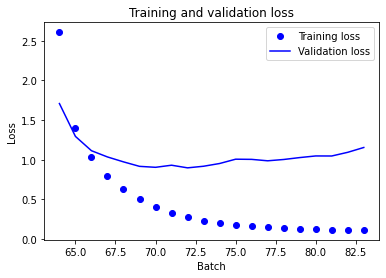

In [44]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

batch = range(64, len(acc) +64)


plt.plot(batch, loss, 'bo', label='Training loss')
plt.plot(batch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()

Loss gets smaller when batch size is reduced, moving close to 0.

# End of HW1